In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import urllib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json


In [2]:
# load data
df = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)

# we need only the text and target column
df = df[['headline', 'is_sarcastic']]

print(df.head())
print('\n ', df.shape)

text = np.array(df['headline'].values)
label = np.array(df['is_sarcastic'].values)

                                            headline  is_sarcastic
0  former versace store clerk sues over secret 'b...             0
1  the 'roseanne' revival catches up to our thorn...             0
2  mom starting to fear son's web series closest ...             1
3  boehner just wants wife to listen, not come up...             1
4  j.k. rowling wishes snape happy birthday in th...             0

  (26709, 2)


In [3]:
# split data into training and validation

train_text, validation_text, train_label, validation_label = train_test_split(text, label, test_size=0.1)

In [4]:
# define parameters for later use

pad_type = 'post' 
trunc_type = 'post'
word_count = 10000 # we will train our model with only top 10000 common words and rest will be excluded 
max_len = 32
threshold = 0.99 # to stop trainng the model once it reaches 90% accuracy
batch_size = 50

In [5]:
# tokenize sentences

tokens = tf.keras.preprocessing.text.Tokenizer(num_words= word_count, oov_token='<OOV>')
tokens.fit_on_texts(train_text)

In [6]:
# get word index and vectors for all sentences

word_index = tokens.word_index

train_seq = tokens.texts_to_sequences(train_text)
validation_seq = tokens.texts_to_sequences(validation_text)


In [7]:
# print a sentence and its sequence and label

print(train_text[1])
print(train_seq[1])
print(train_label[1])

strangers made sure this homeless man and his dog stayed warm during blizzard
[2339, 204, 388, 19, 1000, 14, 9, 32, 202, 6468, 2847, 122, 7831]
0


In [8]:
# padd the sentence sequence for equal length

train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_seq, padding = pad_type, truncating = trunc_type, maxlen = max_len)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_seq, padding  = pad_type, truncating = trunc_type, maxlen = max_len)

In [9]:
# print padded sentence and sequence

print(train_padded[227])
print(train_text[227])
print(train_label[227])

[  12  270 1000 1087   25    8  298 1209 2525 2703    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
new york homeless speak out on government aid, shelter programs
0


In [10]:
print(train_padded.shape)
print(validation_padded.shape)

(24038, 32)
(2671, 32)


In [11]:
# create model 

model = tf.keras.Sequential([
    # add an embedding layer
    tf.keras.layers.Embedding(word_count, 16, input_length=max_len),
    
    # add the bi-lstm layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    
    # add another bi-lstm layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    # add dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.2),
    
    # add a dense layer
    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
    
    # add the prediction layer
    tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid),
])

model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 64)            12544     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 271,873
Trainable params: 271,873
Non-trainable params: 0
__________________________________________________

In [12]:
# define a callback function to stop training when thrshold is reached

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > threshold:
            self.model.stop_training = True
            print(' \n Terminating training as model reached ' + str(threshold * 100) + ' % accuracy \n')

callback_func = myCallback()

In [13]:
history = model.fit(train_padded, train_label, validation_data=(validation_padded, validation_label), epochs = 100, batch_size=batch_size, callbacks = [callback_func], verbose=1)

Epoch 1/100
481/481 [==============================] - 8s 16ms/step - loss: 0.4043 - accuracy: 0.8012 - val_loss: 0.3291 - val_accuracy: 0.8517
Epoch 2/100
481/481 [==============================] - 6s 13ms/step - loss: 0.2142 - accuracy: 0.9137 - val_loss: 0.3269 - val_accuracy: 0.8648
Epoch 3/100
481/481 [==============================] - 7s 14ms/step - loss: 0.1365 - accuracy: 0.9484 - val_loss: 0.4117 - val_accuracy: 0.8675
Epoch 4/100
481/481 [==============================] - 7s 14ms/step - loss: 0.0869 - accuracy: 0.9692 - val_loss: 0.4981 - val_accuracy: 0.8502
Epoch 5/100
481/481 [==============================] - 6s 13ms/step - loss: 0.0609 - accuracy: 0.9794 - val_loss: 0.5410 - val_accuracy: 0.8458
Epoch 6/100
481/481 [==============================] - 6s 13ms/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 0.7731 - val_accuracy: 0.8476
Epoch 7/100
481/481 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9911 
 Terminating training as model reached

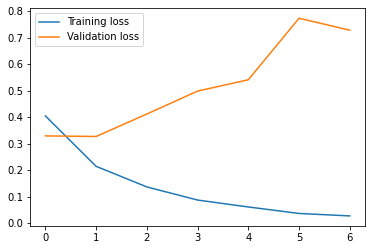

In [14]:
# plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.show()

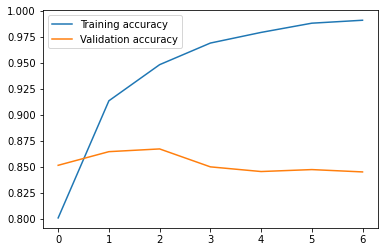

In [15]:
# plot accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [16]:
# extract embedding
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [17]:
# map embeddings to words

reverse_word_index = {v:k for k,v in word_index.items()}

words = []
embeddings = []

for w in range(1, word_count):
    
    words.append(reverse_word_index[w])
    embeddings.append(weights[w])
    
words = np.array(words)
embeddings = np.array(embeddings)

print(words.shape)
print(embeddings.shape)

(9999,)
(9999, 16)


In [18]:
print(words[88])
print(embeddings[88])

before
[ 0.01663598 -0.03528101  0.0072131   0.05724121  0.00502486  0.00923272
  0.01255624  0.0647527  -0.02112299 -0.00747943 -0.08052415 -0.03717985
 -0.03416302 -0.02372855 -0.05815376 -0.0054259 ]


In [19]:
# export for mapping

words = pd.DataFrame(words)
embeddings = pd.DataFrame(embeddings)

words.to_csv('meta.tsv', sep='\t', index=False)
embeddings.to_csv('vecs.tsv', sep='\t', index=False)